In [5]:
import pandas as pd
import numpy as np
import surprise, sklearn, sklearn.model_selection, tqdm
d = pd.read_csv('example_data.csv', sep='\t')
d
# если у вас id имеет строковый тип, то лучше его сконвертировать в int, например, такой командой:
# d['user_id'] = sklearn.preprocessing.LabelEncoder().fit_transform(d['user_id'])

,user_id,item_id,rating
0,0,947,5
1,0,939,5
2,0,938,5
3,0,934,5
4,0,930,2
...,...,...,...
16219144,876144,23175,4
16219145,876144,52873,2
16219146,876144,23370,3
16219147,876144,374106,5


# Предварительные размышления

В предоставленных данных находятся рейтинги товаров, выставленные пользователями, которые их покупали. Магазину выгодно порекомендовать товар, который пользователь с большой вероятностью купит. Какой рекомендовать: с небольшим количеством оценок, но все 5, или тот, который покупало множество людей, но рейтинг ниже? 

Алгоритмы библиотек рекомендательных систем, например, [Suprise](https://surpriselib.com/) стремятся предсказать рейтинг, но нам нужно предсказывать факт покупки. Изменим наш датасет и оценки качества так, чтобы предсказывался и проверялся факт покупки товара.

In [7]:
d.rename({'rating':'buy'}, axis=1, inplace=True)
d['buy'] = 1
d
# теперь в датасете отражен только факт покупки товара (все строки содержат buy=1), 
# а те пары (user_id, item_id), которые не встречаются, соответсвуют не купленным товарам

,user_id,item_id,buy
0,0,947,1
1,0,939,1
2,0,938,1
3,0,934,1
4,0,930,1
...,...,...,...
16219144,876144,23175,1
16219145,876144,52873,1
16219146,876144,23370,1
16219147,876144,374106,1


# Посмотрим на датасет

С помощью метода `Dataframe.groupby('столбец1')['столбец2'].count()` найдите количество товаров, купленных каждым пользователем, и количество пользователей, купивших каждый товар. 

In [24]:
user_buy_counts = d.groupby('user_id')['item_id'].count()
user_buy_counts

user_id
0         294
1          21
2           3
3           1
4           8
         ... 
876131      4
876133      1
876136     64
876142      3
876144      5
Name: item_id, Length: 472638, dtype: int64

In [26]:
item_buy_counts = d.groupby('item_id')['user_id'].count()
item_buy_counts

item_id
0           7
1           3
2           1
3          71
4           1
           ..
2360645     1
2360646     1
2360647     1
2360648     1
2360649     1
Name: user_id, Length: 2360626, dtype: int64

Функцией `np.unique(..., return_counts=True)` вычислите статистику: 
- количество случайных (не постоянных) покупателей (купили только один товар)
- насколько богат самый постоянный покупатель (сколько максимум товаров купил один человек)
- сколько непопулярных товаров (купили только один раз)
- насколько популярны товары первой необходимости (сколько максимум людей купили один товар)

In [48]:
user_buys = user_buy_counts.values 
item_buys = item_buy_counts.values 

unique_user_buys, counts_user_buys = np.unique(user_buys, return_counts=True)
unique_item_buys, counts_item_buys = np.unique(item_buys, return_counts=True)

one_time_buyers = counts_user_buys[unique_user_buys == 1][0] if 1 in unique_user_buys else 0
max_user_buys = unique_user_buys.max()

one_time_items = counts_item_buys[unique_item_buys == 1][0] if 1 in unique_item_buys else 0
max_item_buyers = unique_item_buys.max()

print(f"Количество случайных покупателей (купили только 1 товар): {one_time_buyers}")
print(f"Максимальное количество товаров, купленных одним покупателем: {max_user_buys}")
print(f"Количество непопулярных товаров (купили только один раз): {one_time_items}")
print(f"Максимальное количество покупателей у самого популярного товара: {max_item_buyers}")

Количество случайных покупателей (купили только 1 товар): 90536
Максимальное количество товаров, купленных одним покупателем: 21812
Количество непопулярных товаров (купили только один раз): 1266581
Максимальное количество покупателей у самого популярного товара: 20859


С помощью функции `seaborn.histplot` с параметром `log_scale=True` нарисуйте две гистограммы: 
- распределение популярностей товаров (количеств купивших их людей)
- распределение количеств покупок (сколько людей купили только 1 товар, 2 товара, 3 товара, ...)

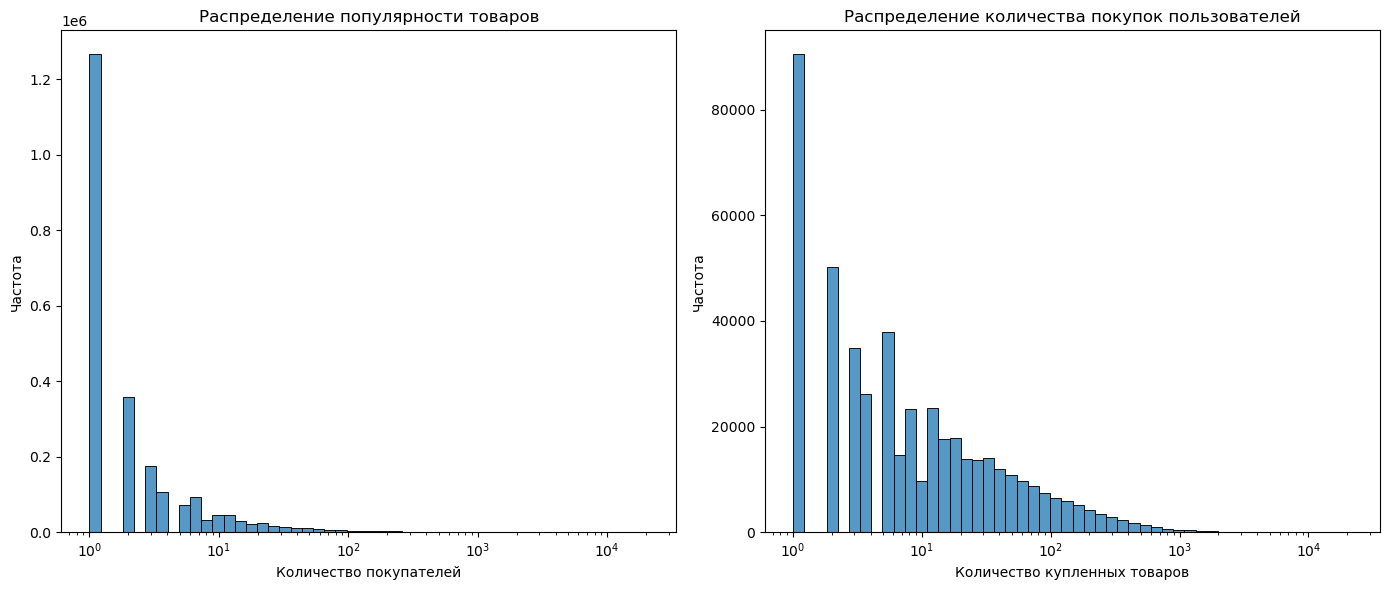

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Популярность товаров (кол-во уникальных покупателей у каждого товара)
popularity = d.groupby('item_id')['user_id'].nunique()

# 2. Количество покупок каждого пользователя (сколько разных товаров купил пользователь)
user_buys_count = d.groupby('user_id')['item_id'].nunique()

# Рисуем гистограммы
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(popularity, log_scale=True, bins=50)
plt.title('Распределение популярности товаров')
plt.xlabel('Количество покупателей')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(user_buys_count, log_scale=True, bins=50)
plt.title('Распределение количества покупок пользователей')
plt.xlabel('Количество купленных товаров')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

# Подготовка обучающей выборки

Делим множество пользователей на train и test. Ответьте в комментариях на вопрос: чем отличается проверка, когда мы делим на train и test пользователей, от проверки, когда мы делим на train и test строки датасета d? (10% баллов)

Изначально train будет содержать только положительные записи о купленных товарах. Туда нужно добавить еще какое-то количество не купленных, иначе алгоритм всем будет предсказывать только 1.

In [ ]:
cold_start = True

all_users = np.unique(d['user_id'])
print('Общее число пользователей:', len(all_users))

# уменьшите, если вам не хватает оперативной памяти
train_size=4000
test_size=100

if cold_start:
    assert train_size+test_size < len(all_users)
    train_users, test_users = sklearn.model_selection.train_test_split(all_users, 
                    train_size=train_size, test_size=test_size, random_state=0)
else:
    train_users = np.random.choice(all_users, size=train_size, replace=False)
    assert test_size <= train_size
    test_users = np.random.choice(train_users, size=test_size, replace=False)

d_train = d.loc[np.isin(d['user_id'], train_users)].reset_index(drop=True)
d_test = d.loc[np.isin(d['user_id'], test_users)].reset_index(drop=True)

print('Размер обучающей выборки', len(d_train))
print('Среднее число покупок у одного человека', len(d_train)/train_size)

# добавляем в d_train товары, которые пользователи не покупали и присваиваем им минимальный рейтинг
# у меня самый хороший результат получился, когда добавляешь столько же не купленных товаров, сколько
# в среднем покупают пользователи
toAdd_for_each_user = 30
toAdd = np.zeros((toAdd_for_each_user,3))
all_items = np.unique(np.concatenate((d_train['item_id'],d_test['item_id'])))
n_items = len(all_items)
print('Общее число товаров:', n_items)
np.random.seed(0)
for i in tqdm.tqdm(range(train_size)):
    user_id = train_users[i]
    ind_for_1_user = np.where(d_train['user_id'] == user_id)[0]
    buy = d_train.loc[ind_for_1_user,'item_id']
    not_buy = id товаров, которые этот пользователь не покупал (см. np.setdiff1d)  # TODO!!!
    toAdd[:,0] = user_id
    toAdd[:,1] = случайное подмножество not_buy нужного размера  # TODO!!!
    if not cold_start and len(buy) > 1:
        # выбрасываем из train часть купленных товаров, чтобы они попали в тест
        d_train.drop(ind_for_1_user[len(ind_for_1_user)//2:], axis=0, inplace=True)
    d_train = pd.concat((d_train, pd.DataFrame(toAdd, columns=d_train.columns)), axis=0)
    d_train.reset_index(drop=True, inplace=True)
print('Размер расширенной обучающей выборки', len(d_train))

# Тренировка

In [ ]:
# Порядок столбцов для surprise очень важен: user_id, item_id и рейтинг
surprise_d_train = surprise.Dataset.load_from_df(d_train[['user_id','item_id','buy']], 
                        surprise.Reader(rating_scale=(0,1))).build_full_trainset()

In [ ]:
method = surprise.SVD()
method.fit(surprise_d_train)

# Расширение тестового датасета

Расширим test товарами, которые пользователи не покупали, и предскажем факт покупки для расширенного test. В отличие от train здесь придется добавить все без исключения товары, чтобы предсказать рекомендации для всех. 

Так как количество товаров очень большое, то в тесте не должно быть много пользователей.

In [ ]:
def get_true_test_for_one_user(d_test, user_id):
    if cold_start:
        # пользователь не встречается в train вовсе - добавляем в test все товары
        extended_true_test = np.zeros(n_items)
        ind_for_1_user = d_test['user_id'] == user_id
        buy = id товаров, которые этот пользователь покупал  # TODO!!!
        extended_true_test[индексы (логические) тех id из all_items, которые покупал] = 1  # TODO!!! (см. np.isin)
        return extended_true_test, all_items
    else:
        # тестируем только на купленных товарах данного пользователя в test 
        # и на тех некупленных товарах, факты о некупли которых не содержатся в train
        ind_for_1_user = d_test['user_id'] == user_id
        buy_test = np.unique(d_test.loc[d_test['user_id'] == user_id, 'item_id'])
        buy_train = np.unique(d_train.loc[(d_train['user_id']==user_id) & (d_train['buy']==1), 'item_id'])
        all_buy = np.union1d(buy_train, buy_test)
        not_buy = np.setdiff1d(all_items, all_buy)
        not_buy_train = np.unique(d_train.loc[(d_train['user_id']==user_id) & (d_train['buy']==0), 'item_id'])
        not_buy_test = np.setdiff1d(not_buy, not_buy_train)
        all_items_test = np.union1d(buy_test, not_buy_test)
        extended_true_test = np.zeros(len(all_items_test))
        extended_true_test[np.isin(all_items_test, buy_test)] = 1
        return extended_true_test, all_items_test

# Предсказание

In [ ]:
def get_predicted_test_for_one_user(method, user_id, all_items_for_1_user):
    extended_predicted_test = np.zeros(len(all_items_for_1_user))
    for i, item_id in enumerate(all_items_for_1_user):
        extended_predicted_test[i] = предсказание для user_id и i-того товара из all_items  # TODO!!!
    return extended_predicted_test

# Оценка качества [MAP@k](https://habr.com/ru/companies/econtenta/articles/303458/)

In [ ]:
def AP_at_k(predictions_for_1_user, true_for_1_user, k):
    max_ind = np.argpartition(-predictions_for_1_user, k)[:k]
    max_predictions = predictions_for_1_user[max_ind]
    true = true_for_1_user[max_ind]
    # сортируем максимальные k предсказаний
    i = np.argsort(-max_predictions)
    max_predictions = max_predictions[i]
    true = true[i]
    # считаем AP, усредняя Precision для всех 1
    ones_ind = np.where(true == 1)[0]
    if len(ones_ind) == 0: return 0
    precision = np.zeros(len(ones_ind))
    for j in range(len(ones_ind)):
        ind_of_one = ones_ind[j]
        precision[j] = Precision для (ind_of_one+1) первых элементов  # TODO!!!
    return np.mean(precision)

k = 100
APs = np.zeros(test_size)
for i in tqdm.tqdm(range(test_size)):
    user_id = test_users[i]
    true_for_1_user, all_items_for_1_user =   # TODO!!!
    predictions_for_1_user =   # TODO!!!
    APs[i] = AP_at_k(predictions_for_1_user, true_for_1_user, k)

MAP = np.mean(APs)
print(f'MAP@{k} =', MAP)
correct = 0.05341 if cold_start else 0.04978
assert np.isclose(MAP,correct,atol=0.002), 'В вашу программу закралась ошибка. Найдите и исправьте ее'